In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import torch
import copy
import torch.nn as nn
import matplotlib.pyplot as plt
import warnings
import threading
from threading import Semaphore

# Ignore warnings
warnings.filterwarnings('ignore')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
FILE_PATH = 'London_Weather.csv'

<center><img src='Process.jpg' /></center>

- **Preprocessing** prepares the data and feeds it into two shared buffers.
- **Training** and **Inference** consumes data from these buffers.
- Threads communicate or sync using **semaphores** (`.wait()` and `.set()`) and **mutexes** to avoid clashes with shared resources.
- Ensures safe concurrent execution.

In [2]:
CAPACITY = 15  # Number of batches to store in buffer
TRAINER_READ_THRESHOLD = 3  # Number of batches for training
INFERENCE_READ_THRESHOLD = 1  # Number of batches for inference

# Simulated processing times (seconds)
PREPROCESSING_WAIT_TIME = 1  # Data loading is I/O bound (Fastest)
TRAINER_WAIT_TIME = 4  # Training is compute intensive (Slowest)
INFERENCE_WAIT_TIME = 1  # Inference (Moderate)
ANALYSIS_WAIT_TIME = 0.3  # Analysis is typically quick
DISPLAY_WAIT_TIME = 0.7  # Display/Visualization takes some time

# Create shared data buffers
# Two buffers: one for Training, one for Inference
data_buffer1 = [None] * CAPACITY  # Stores Training batches (Batch, Sequence, Features)
data_buffer2 = [None] * CAPACITY  # Stores Individual datapoints

# Ensures mutual exclusion for buffer access
mutex1 = Semaphore(1)  # Protects access to buffer1
mutex2 = Semaphore(1)  # Protects access to buffer2

# Tracks the Empty Slots in the buffer
empty1 = Semaphore(CAPACITY)  # Counts empty slots in buffer1
empty2 = Semaphore(CAPACITY)  # Counts empty slots in buffer2

# Tracks the Filled Slots in the buffer
full1 = Semaphore(0)  # Counts filled slots in buffer1
full2 = Semaphore(0)  # Counts filled slots in buffer2

# Events to track completion
preprocessing_done = threading.Event()
preprocessing_test_data_ready = threading.Event()  # Event to signal test data is ready
training_done = threading.Event()
inference_done = threading.Event()
analysis_done = threading.Event()
display_done = threading.Event()

# Shared Dictionaries to store results
training_results = {}  # Store results from Training
inference_results = {}  # Store results from Inference
analysis_results = {}  # Store results from Analysis

# Mutex for accessing shared result dictionaries
results_mutex = threading.Lock()

In [3]:
class Preprocessing(threading.Thread):
    def __init__(self, file_path):
        threading.Thread.__init__(self)
        self.file_path = file_path
        self.data = None
        self.scaler = None
        self.normalized_data = None
        self.train_size = None
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        self.T = 20  # Making prediction based on sequence of T past values

    def load_data(self):
        self.data = pd.read_csv(self.file_path)  # Read the CSV File
        return self.data

    def clean_data(self):
        # Convert date to datetime format
        self.data['date'] = pd.to_datetime(self.data['date'], format='%Y%m%d')

        # Fill missing values in snow_depth with 0
        self.data['snow_depth'].fillna(0, inplace=True)

        # Drop rows with any NaN values
        self.data.dropna(inplace=True)

        return self.data

    def prepare_data_for_model(self, train_ratio=0.8, target_column='mean_temp'):
        # Separate features and target
        input_data = self.data.drop(['date'], axis=1)  # Remove date column as it's not a feature
        targets = self.data[target_column].values

        # Define dimensions
        D = input_data.shape[1]  # Number of features
        N = len(input_data) - self.T  # Total number of sequences

        # Calculate train size
        self.train_size = int(len(input_data) * train_ratio)

        # Normalize input data
        self.scaler = StandardScaler()
        self.scaler.fit(input_data[:self.train_size + self.T - 1])
        self.normalized_data = self.scaler.transform(input_data)

        # Prepare X_train and y_train
        self.X_train = np.zeros((self.train_size, self.T, D))
        self.y_train = np.zeros((self.train_size, 1))

        for t in range(self.train_size):
            self.X_train[t, :, :] = self.normalized_data[t:t+self.T]
            self.y_train[t] = targets[t+self.T]

        # Prepare X_test and y_test
        self.X_test = np.zeros((N - self.train_size, self.T, D))
        self.y_test = np.zeros((N - self.train_size, 1))

        for i in range(N - self.train_size):
            t = i + self.train_size
            self.X_test[i, :, :] = self.normalized_data[t:t+self.T]
            self.y_test[i] = targets[t+self.T]

        # Convert to PyTorch tensors
        self.X_train = torch.from_numpy(self.X_train.astype(np.float32))
        self.y_train = torch.from_numpy(self.y_train.astype(np.float32))
        self.X_test = torch.from_numpy(self.X_test.astype(np.float32))
        self.y_test = torch.from_numpy(self.y_test.astype(np.float32))

        return self.X_train, self.y_train, self.X_test, self.y_test

    def run(self):
        # Preprocess start time
        start_time_pre = time.time()

        # Load and prepare data
        self.load_data()
        self.clean_data()
        X_train, y_train, X_test, y_test = self.prepare_data_for_model(target_column='mean_temp')

        # Store test data first so Training thread can access it
        with results_mutex:
            training_results['original_data'] = self.data
            training_results['X_test'] = self.X_test
            training_results['y_test'] = self.y_test

        # Signal that test data is ready for Training thread
        preprocessing_test_data_ready.set()

        # Calculate batch size to divide data into CAPACITY chunks
        batch_size = max(1, len(X_train) // CAPACITY)

        # Fill both buffers with batches
        datapoints_loaded = 0
        in_index1 = 0  # Indices for Buffer 1 (Training)
        in_index2 = 0  # Indices for Buffer 2 (Inference)

        while datapoints_loaded < CAPACITY:
            # Simulate processing time (I/O bound)
            time.sleep(PREPROCESSING_WAIT_TIME)

            # Create a batch boundaries
            start_idx = datapoints_loaded * batch_size
            end_idx = min(start_idx + batch_size, len(X_train))

            # Prevent out-of-bounds
            if start_idx >= len(X_train):
                break

            # Get batch of data
            batch_X = X_train[start_idx:end_idx]
            batch_y = y_train[start_idx:end_idx]

            # Fill buffer 1 for training (chunks)
            empty1.acquire()  # Wait for empty slot
            mutex1.acquire()  # Acquire Lock (Mutual Exclusion, Thread Safe Access)
            data_buffer1[in_index1] = (batch_X, batch_y)  # Store batch in buffer
            print(f"[PREPROCESSING] Added batch to training buffer at index: {in_index1}, batch size: {len(batch_X)}")
            in_index1 = (in_index1 + 1) % CAPACITY  # Update index of the buffer
            mutex1.release()  # Release Lock
            full1.release()  # Buffer slot is full (Permit to consume)

            # Fill buffer 2 for inference (single datapoints)
            empty2.acquire()  # Wait for empty slot
            mutex2.acquire()  # Acquire Lock (Mutual Exclusion, Thread Safe Access)
            # Stores individual datapoints for inference
            data_buffer2[in_index2] = (X_test[datapoints_loaded % len(X_test):datapoints_loaded % len(X_test) + 1],
                                      y_test[datapoints_loaded % len(X_test):datapoints_loaded % len(X_test) + 1])
            print(f"[PREPROCESSING] Added datapoint to inference buffer at index: {in_index2}")
            in_index2 = (in_index2 + 1) % CAPACITY  # Update index of the buffer
            mutex2.release()  # Release Lock
            full2.release()  # Buffer slot is full (Permit to consume)

            datapoints_loaded += 1

        end_time_pre = time.time()
        print(f"[PREPROCESSING] Completed in {end_time_pre - start_time_pre:.2f} seconds")

        # Set the Preprocessing event as completed
        # Other threads are waiting for this event set (.wait())
        preprocessing_done.set()

LSTM is a type of RNN that aims to mitigate the vanishing gradient problem, which is commonly encountered in traditional RNNs. The vanishing gradient problem is essentially where the gradients used to update the RNN become so small that it no longer updates the weights of the RNN sufficiently, which can lead to loss of 'memory'. The way that LSTM addresses this is by improving the architecture in such a way where we not only have our working memory (i.e. short-term memory) but also our carry-on memory (i.e. long-term memory).

[Pytorch's page on LSTMs](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html).

In [4]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.M = hidden_dim  # Size of the hidden state vector
        self.L = layer_dim  # Number of LSTM layers

        self.rnn = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=layer_dim,
            batch_first=True  # batch_first to have (batch dim, seq dim, feature dim)
        )

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, X):
        # Set device
        device = X.device

        # Initial hidden state (Short term) and cell state (Long term)
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

        out, (hn, cn) = self.rnn(X, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [5]:
class Training(threading.Thread):
    def __init__(self):
        threading.Thread.__init__(self)
        self.model = None
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.all_train_losses = []
        self.all_test_losses = []

    def create_model(self, input_dim, hidden_dim=512, layer_dim=2, output_dim=1):
        self.model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)
        self.model.to(self.device)
        return self.model

    def train_model(self, X_train, y_train, X_test, y_test, learning_rate=0.01, epochs=40):
        # Move data to device
        X_train, y_train = X_train.to(self.device), y_train.to(self.device)
        X_test, y_test = X_test.to(self.device), y_test.to(self.device)

        # Initialize optimizer and criterion
        criterion = nn.MSELoss()
        optimizer = torch.optim.SGD(
            self.model.parameters(),
            lr=learning_rate,
            momentum=0.9,
            weight_decay=1e-4
        )

        # Arrays to store losses for each epoch
        train_losses = np.zeros(epochs)
        test_losses = np.zeros(epochs)

        # Training loop
        for epoch in range(epochs):
            # Forward pass
            optimizer.zero_grad()
            outputs = self.model(X_train)
            loss = criterion(outputs, y_train)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            # Store train loss
            train_losses[epoch] = loss.item()

            # Calculate validation loss
            with torch.no_grad():
                test_outputs = self.model(X_test)
                test_loss = criterion(test_outputs, y_test).item()
                test_losses[epoch] = test_loss

        return train_losses, test_losses

    def run(self):
        # Training start time
        start_time_train = time.time()

        # Wait for test data to be available
        preprocessing_test_data_ready.wait()

        # Read data from buffer in chunks
        read_datapoints = 0
        out_index = 0

        # Wait for first data batch
        full1.acquire()  # Wait until buffer has at least one batch
        mutex1.acquire()  # Acquire Lock

        # Get first batch to determine dimensions for model creation
        batch_X, batch_y = data_buffer1[0]
        input_dim = batch_X.shape[2]  # Number of features

        # Create model with the input dimension
        self.model = self.create_model(input_dim=input_dim)

        mutex1.release()  # Release Lock
        full1.release()  # Release Permit

        # Train the model
        while read_datapoints < CAPACITY:
            # Determine number of batches to read
            batch_count = min(TRAINER_READ_THRESHOLD, CAPACITY - read_datapoints)

            # Skip if no more batches to read
            if batch_count <= 0:
                break

            # Acquire permits for batches
            for _ in range(batch_count):
                full1.acquire()  # Wait until buffer has data

            mutex1.acquire()  # Acquire Lock

            # Collect data chunks for training
            trainer_data_to_load = []
            trainer_targets_to_load = []

            # Read batches
            for i in range(batch_count):
                idx = (out_index + i) % CAPACITY  # Get index of the buffer
                if data_buffer1[idx] is not None:
                    batch_X, batch_y = data_buffer1[idx]  # Get batch data
                    trainer_data_to_load.append(batch_X)
                    trainer_targets_to_load.append(batch_y)

            print(f"[TRAINING] Read {batch_count} batches from indices: {out_index} to {(out_index + batch_count - 1) % CAPACITY}")

            # Update buffer index and counter
            out_index = (out_index + batch_count) % CAPACITY
            read_datapoints += batch_count

            mutex1.release()  # Release Lock

            # Release permits for consumed batches
            for _ in range(batch_count):
                empty1.release()  # Signal empty slot in buffer

            # Combine batches for training
            if len(trainer_data_to_load) > 0:
                # Combine batches if we have more than one
                if len(trainer_data_to_load) > 1:
                    combined_X = torch.cat(trainer_data_to_load)
                    combined_y = torch.cat(trainer_targets_to_load)
                else:
                    combined_X = trainer_data_to_load[0]
                    combined_y = trainer_targets_to_load[0]

                # Get validation data
                with results_mutex:
                    X_test_sample = training_results['X_test'][:100]
                    y_test_sample = training_results['y_test'][:100]

                # Multi-epoch training with validation
                batch_train_losses, batch_test_losses = self.train_model(
                    combined_X, combined_y,
                    X_test_sample, y_test_sample,
                    learning_rate=0.01,
                    epochs=40
                )

                # Store losses for plotting
                self.all_train_losses.extend(batch_train_losses)
                self.all_test_losses.extend(batch_test_losses)

        end_time_train = time.time()
        print(f"[TRAINING] Completed in {end_time_train - start_time_train:.2f} seconds")

        # Store training results for other threads to access
        with results_mutex:
            training_results['model'] = copy.deepcopy(self.model)
            training_results['train_losses'] = self.all_train_losses
            training_results['test_losses'] = self.all_test_losses

        # Set the Training event as completed
        # Actions in other threads are waiting for this event set (.wait())
        training_done.set()

In [6]:
class Inference(threading.Thread):
    def __init__(self):
        threading.Thread.__init__(self)
        self.model = None
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.predictions = []

    def set_model(self, model):
        self.model = model
        self.model.to(self.device)

    def predict(self, X_test):
        # Ensure data is on the device
        X_test = X_test.to(self.device)

        # Set model to evaluation mode
        self.model.eval()  # Disables Dropout and BatchNorm

        # Make prediction
        with torch.no_grad():  # No need to track the gradients
            prediction = self.model(X_test)[0, 0].item()

        return prediction

    def predict_all(self, X_test):
        # Move data to device
        X_test = X_test.to(self.device)

        # Set model to evaluation mode
        self.model.eval()

        # Store predictions
        all_predictions = []

        # Generate predictions batch by batch to avoid memory issues
        with torch.no_grad():
            batch_size = 64  # Process in chunks to manage memory
            for i in range(0, len(X_test), batch_size):
                batch = X_test[i:i+batch_size]
                outputs = self.model(batch)
                all_predictions.extend(outputs.cpu().numpy().flatten())

        return all_predictions

    def run(self):
        # Inference start time
        start_time_inf = time.time()

        # Wait for training to provide a model
        training_done.wait()

        # Get the trained model
        with results_mutex:
            self.model = training_results['model']
            X_test_full = training_results['X_test']

        # Generate predictions for all test data
        all_predictions = self.predict_all(X_test_full)

        # Also perform the original buffer-based inference
        read_datapoints = 0
        out_index = 0
        buffer_predictions = []

        while read_datapoints < CAPACITY:
            # Simulate processing time
            time.sleep(INFERENCE_WAIT_TIME)

            # Acquire permits for INFERENCE_READ_THRESHOLD datapoints
            batch_count = min(INFERENCE_READ_THRESHOLD, CAPACITY - read_datapoints)
            for _ in range(batch_count):
                full2.acquire()  # Wait until buffer has data

            mutex2.acquire()  # Acquire Lock (Mutual Exclusion, Thread Safe Access)

            # Read test examples
            for i in range(batch_count):
                idx = (out_index + i) % CAPACITY
                if data_buffer2[idx] is not None:
                    test_X, test_y = data_buffer2[idx]

                    # Make prediction
                    prediction = self.predict(test_X)
                    buffer_predictions.append(prediction)

            # Update buffer index
            out_index = (out_index + batch_count) % CAPACITY
            read_datapoints += batch_count

            mutex2.release()  # Release Lock

            # Release permits for consumed datapoints
            for _ in range(batch_count):
                empty2.release()  # Signal empty slot in buffer

        end_time_inf = time.time()
        print(f"[INFERENCE] Completed in {end_time_inf - start_time_inf:.2f} seconds")

        # Store inference results for analysis
        with results_mutex:
            inference_results['predictions'] = all_predictions
            inference_results['buffer_predictions'] = buffer_predictions
            if 'y_test' in training_results:
                inference_results['y_test'] = training_results['y_test'][:len(all_predictions)]

        # Set the Inference event as completed
        # Actions in other threads are waiting for this event set (.wait())
        inference_done.set()

In [7]:
class Analysis(threading.Thread):
    def __init__(self):
        threading.Thread.__init__(self)
        self.true_values = None
        self.predictions = None
        self.metrics = {}
        self.errors = None
        self.error_stats = {}

    def calculate_metrics(self):
        # Calculate MAE
        self.metrics['MAE'] = mean_absolute_error(self.true_values, self.predictions)

        # Calculate MSE
        self.metrics['MSE'] = mean_squared_error(self.true_values, self.predictions)

        # Calculate RMSE
        self.metrics['RMSE'] = np.sqrt(self.metrics['MSE'])

        print(f"[ANALYSIS] Metrics - MAE: {self.metrics['MAE']:.3f}, MSE: {self.metrics['MSE']:.3f}, RMSE: {self.metrics['RMSE']:.3f}")
        return self.metrics

    def analyze_error_distribution(self):
        # Calculate errors
        self.errors = self.true_values.flatten() - np.array(self.predictions)

        # Basic statistics of errors
        self.error_stats = {
            'mean': np.mean(self.errors),
            'std': np.std(self.errors),
            'min': np.min(self.errors),
            'max': np.max(self.errors)
        }

        print(f"[ANALYSIS] Error stats - Mean: {self.error_stats['mean']:.3f}, Std: {self.error_stats['std']:.3f}")
        return self.errors, self.error_stats

    def run(self):
        # Analysis start time
        start_time_ana = time.time()

        # Wait for training and inference to complete
        inference_done.wait()

        # Simulate processing time
        time.sleep(ANALYSIS_WAIT_TIME)

        # Get predictions and true values
        with results_mutex:
            self.predictions = inference_results['predictions']
            self.true_values = inference_results['y_test'].numpy()

        # Calculate metrics
        self.calculate_metrics()

        # Analyze error distribution
        self.analyze_error_distribution()

        end_time_ana = time.time()
        print(f"[ANALYSIS] Completed in {end_time_ana - start_time_ana:.2f} seconds")

        # Store analysis results
        with results_mutex:
            analysis_results['metrics'] = self.metrics
            analysis_results['errors'] = self.errors
            analysis_results['error_stats'] = self.error_stats

        # Set the Analysis event as completed
        # Other threads are waiting for this event set (.wait())
        analysis_done.set()

In [8]:
class Display(threading.Thread):
    def __init__(self):
        threading.Thread.__init__(self)
        self.data = None
        self.predictions = None
        self.dates = None
        self.plot_df = None
        self.test_target = None
        self.test_predictions = None
        self.train_losses = None
        self.test_losses = None
        self.errors = None

    def prepare_plot_data(self):
        # Get data from shared results
        with results_mutex:
            self.data = training_results['original_data']
            self.predictions = inference_results['predictions']
            self.test_target = inference_results['y_test']
            self.train_losses = training_results['train_losses']
            self.test_losses = training_results['test_losses']
            self.errors = analysis_results['errors'] if 'errors' in analysis_results else None

        # Prepare the plot DataFrame
        # Use proper alignment for test data
        train_size = int(len(self.data) * 0.8)  # Same ratio as in preprocessing
        test_start_idx = train_size + 20  # Adding sequence length (T) from preprocessing

        # Create a deep copy of the date and temperature columns
        self.plot_df = self.data[['date', 'mean_temp']].copy(deep=True)

        # Select the test portion that corresponds to our predictions
        self.plot_df = self.plot_df.iloc[test_start_idx:test_start_idx + len(self.predictions)]

        # Add predictions column
        self.plot_df['prediction'] = self.predictions[:len(self.plot_df)]

        # Set date as index for time-series plotting
        self.plot_df.set_index('date', inplace=True)

        # Show sample of prediction dataframe
        print("[DISPLAY] Sample of prediction dataframe:")
        print(self.plot_df.head(5))

    def plot_results(self, title=None, figsize=(20, 10)):
        plt.figure(figsize=figsize)
        plt.plot(self.plot_df['mean_temp'], label='Actual Temperature', linewidth=1)
        plt.plot(self.plot_df['prediction'], label='Predicted Temperature', linewidth=1)
        plt.xlabel('Date')
        plt.ylabel('Temperature (°C)')
        plt.legend(loc='lower right')

        if title:
            plt.title(title)

        plt.tight_layout()
        plt.show()

    def plot_training_history(self, figsize=(12, 8)):
        plt.figure(figsize=figsize)
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.test_losses, label='Test Loss')
        plt.xlabel('Epoch No')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Validation Loss')
        plt.tight_layout()
        plt.show()

    def plot_by_year(self, figsize=(20, 10)):
        # Group data by year
        plot_df_by_years = []
        for y in self.plot_df.index.year.unique():
            plot_df_by_years.append((y, self.plot_df.loc[self.plot_df.index.year == y]))

        # Plot each year separately
        for year, year_df in plot_df_by_years:
            plt.figure(figsize=figsize)
            plt.plot(year_df['mean_temp'], label='Actual Temperature', linewidth=1)
            plt.plot(year_df['prediction'], label='One-step Prediction', linewidth=1)
            plt.xlabel('Date')
            plt.ylabel('Temperature (°C)')
            plt.legend(loc='lower right')
            plt.title(f'Temperature in {year}')
            plt.tight_layout()
            plt.show()

    def analyze_lstm_error(self):
        if self.test_target is None or self.predictions is None:
            print("[DISPLAY] Test data not set for LSTM error analysis")
            return None, None

        # Convert to numpy if tensor
        test_target_np = self.test_target.numpy() if hasattr(self.test_target, 'numpy') else self.test_target

        # Create error analysis dataframe - match lengths
        targets = test_target_np.flatten()[:len(self.predictions)]
        predictions = self.predictions[:len(targets)]

        LSTM_error = pd.DataFrame(targets, columns=['targets'])
        LSTM_error['predictions'] = predictions
        LSTM_error['error'] = LSTM_error['targets'] - LSTM_error['predictions']
        LSTM_error['error_square'] = LSTM_error['error'] ** 2
        err = LSTM_error['error_square'].mean()
        print(f'[DISPLAY] Mean square error is: {err:.3f}')

        # Plot error histogram
        plt.figure(figsize=(12, 8))
        plt.hist(LSTM_error['error'], bins=25)
        plt.xlabel('Temperature Difference (real - predicted)')
        plt.ylabel('Count')
        plt.title('Distribution of Differences')
        plt.show()

        return LSTM_error, err

    def run(self):
        # Display start time
        start_time_dis = time.time()

        # Wait for analysis to complete
        analysis_done.wait()

        # Simulate processing time
        time.sleep(DISPLAY_WAIT_TIME)

        # Prepare plot data
        self.prepare_plot_data()

        # Generate plots
        self.plot_training_history()
        self.plot_results(title="Actual vs Predicted Temperature")
        self.plot_by_year()

        # Analyze LSTM error
        lstm_error_df, mse = self.analyze_lstm_error()

        end_time_dis = time.time()
        print(f"[DISPLAY] Completed in {end_time_dis - start_time_dis:.2f} seconds")

        # Set the Display event as completed
        # Other threads are waiting for this event set (.wait())
        display_done.set()

[PREPROCESSING] Added batch to training buffer at index: 0, batch size: 813
[PREPROCESSING] Added datapoint to inference buffer at index: 0
[PREPROCESSING] Added batch to training buffer at index: 1, batch size: 813
[PREPROCESSING] Added datapoint to inference buffer at index: 1
[PREPROCESSING] Added batch to training buffer at index: 2, batch size: 813
[PREPROCESSING] Added datapoint to inference buffer at index: 2
[TRAINING] Read 3 batches from indices: 0 to 2
[PREPROCESSING] Added batch to training buffer at index: 3, batch size: 813
[PREPROCESSING] Added datapoint to inference buffer at index: 3
[PREPROCESSING] Added batch to training buffer at index: 4, batch size: 813
[PREPROCESSING] Added datapoint to inference buffer at index: 4
[PREPROCESSING] Added batch to training buffer at index: 5, batch size: 813
[PREPROCESSING] Added datapoint to inference buffer at index: 5
[PREPROCESSING] Added batch to training buffer at index: 6, batch size: 813
[PREPROCESSING] Added datapoint to in

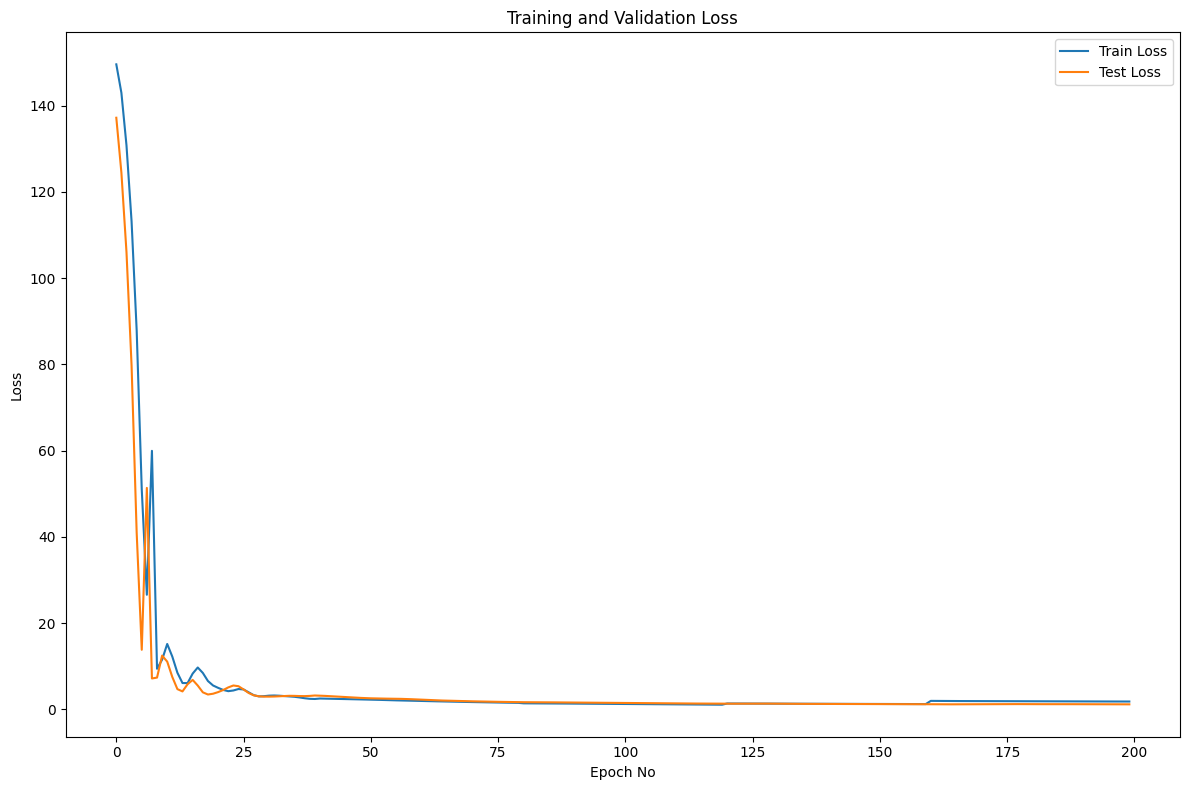

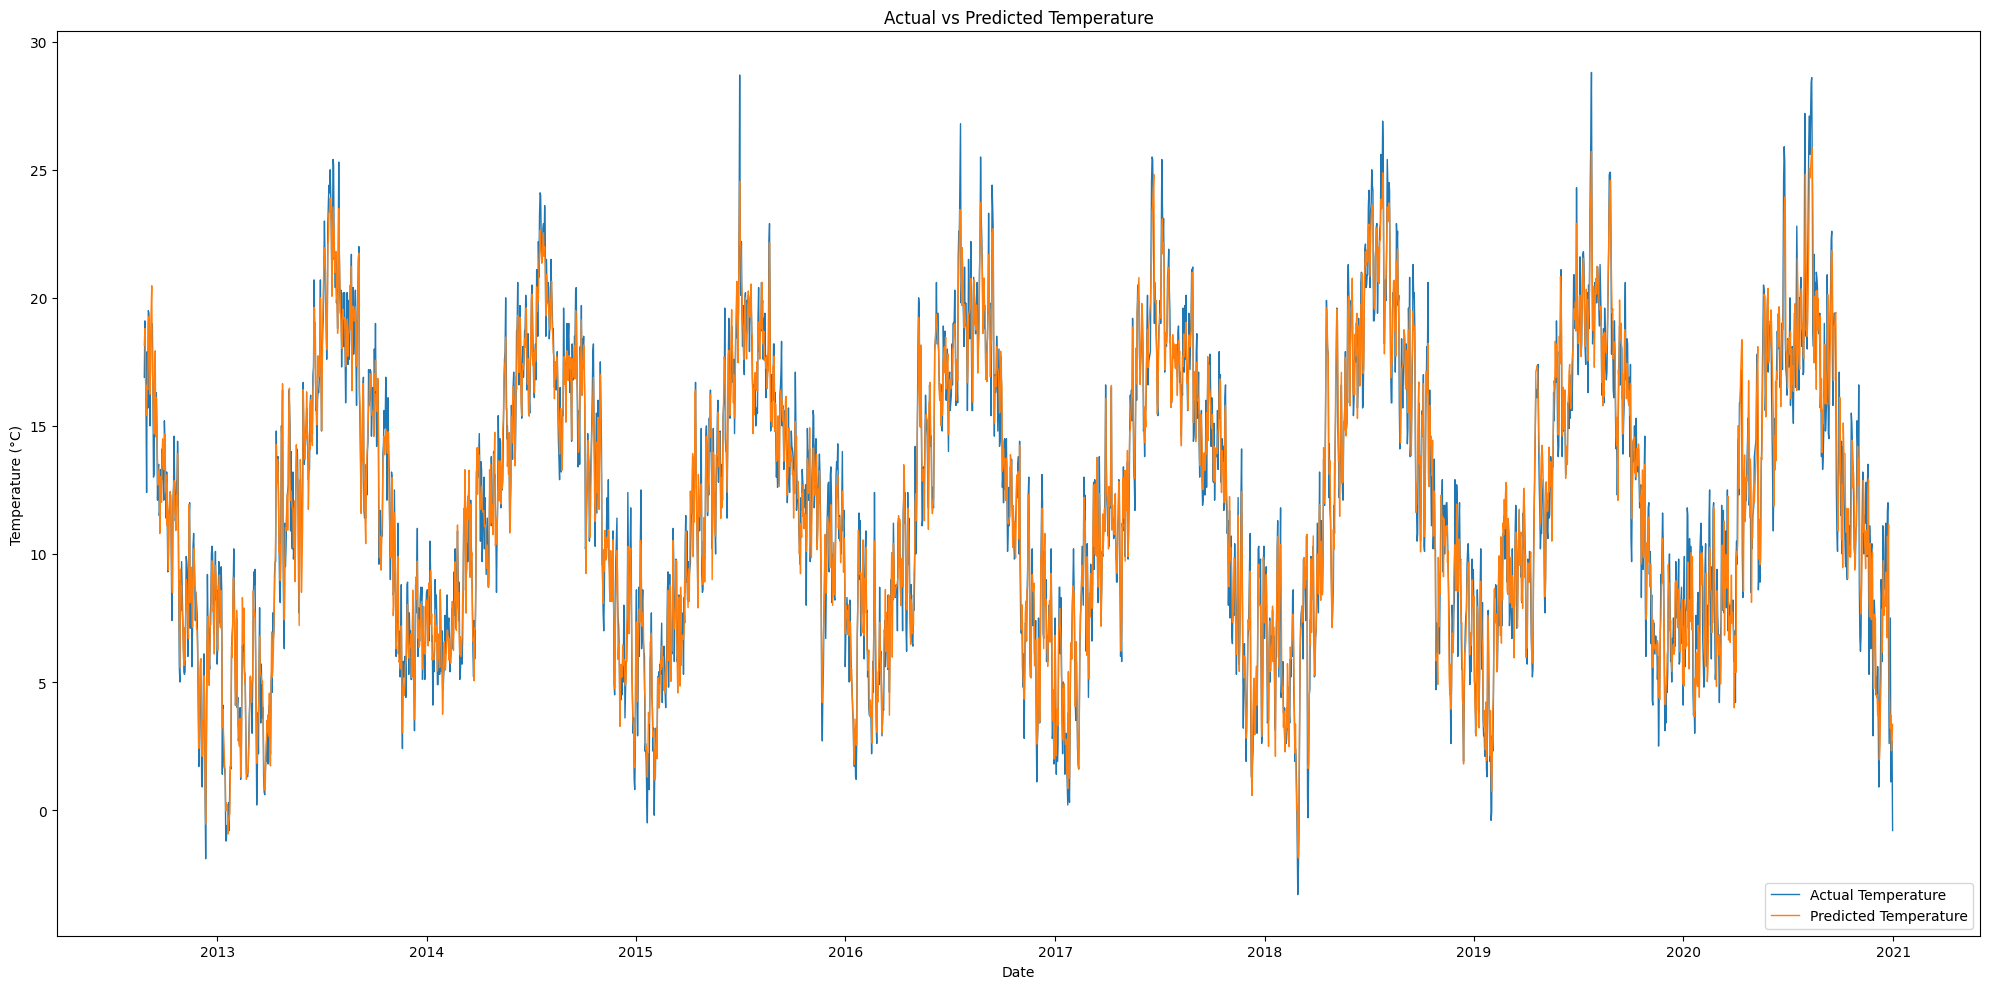

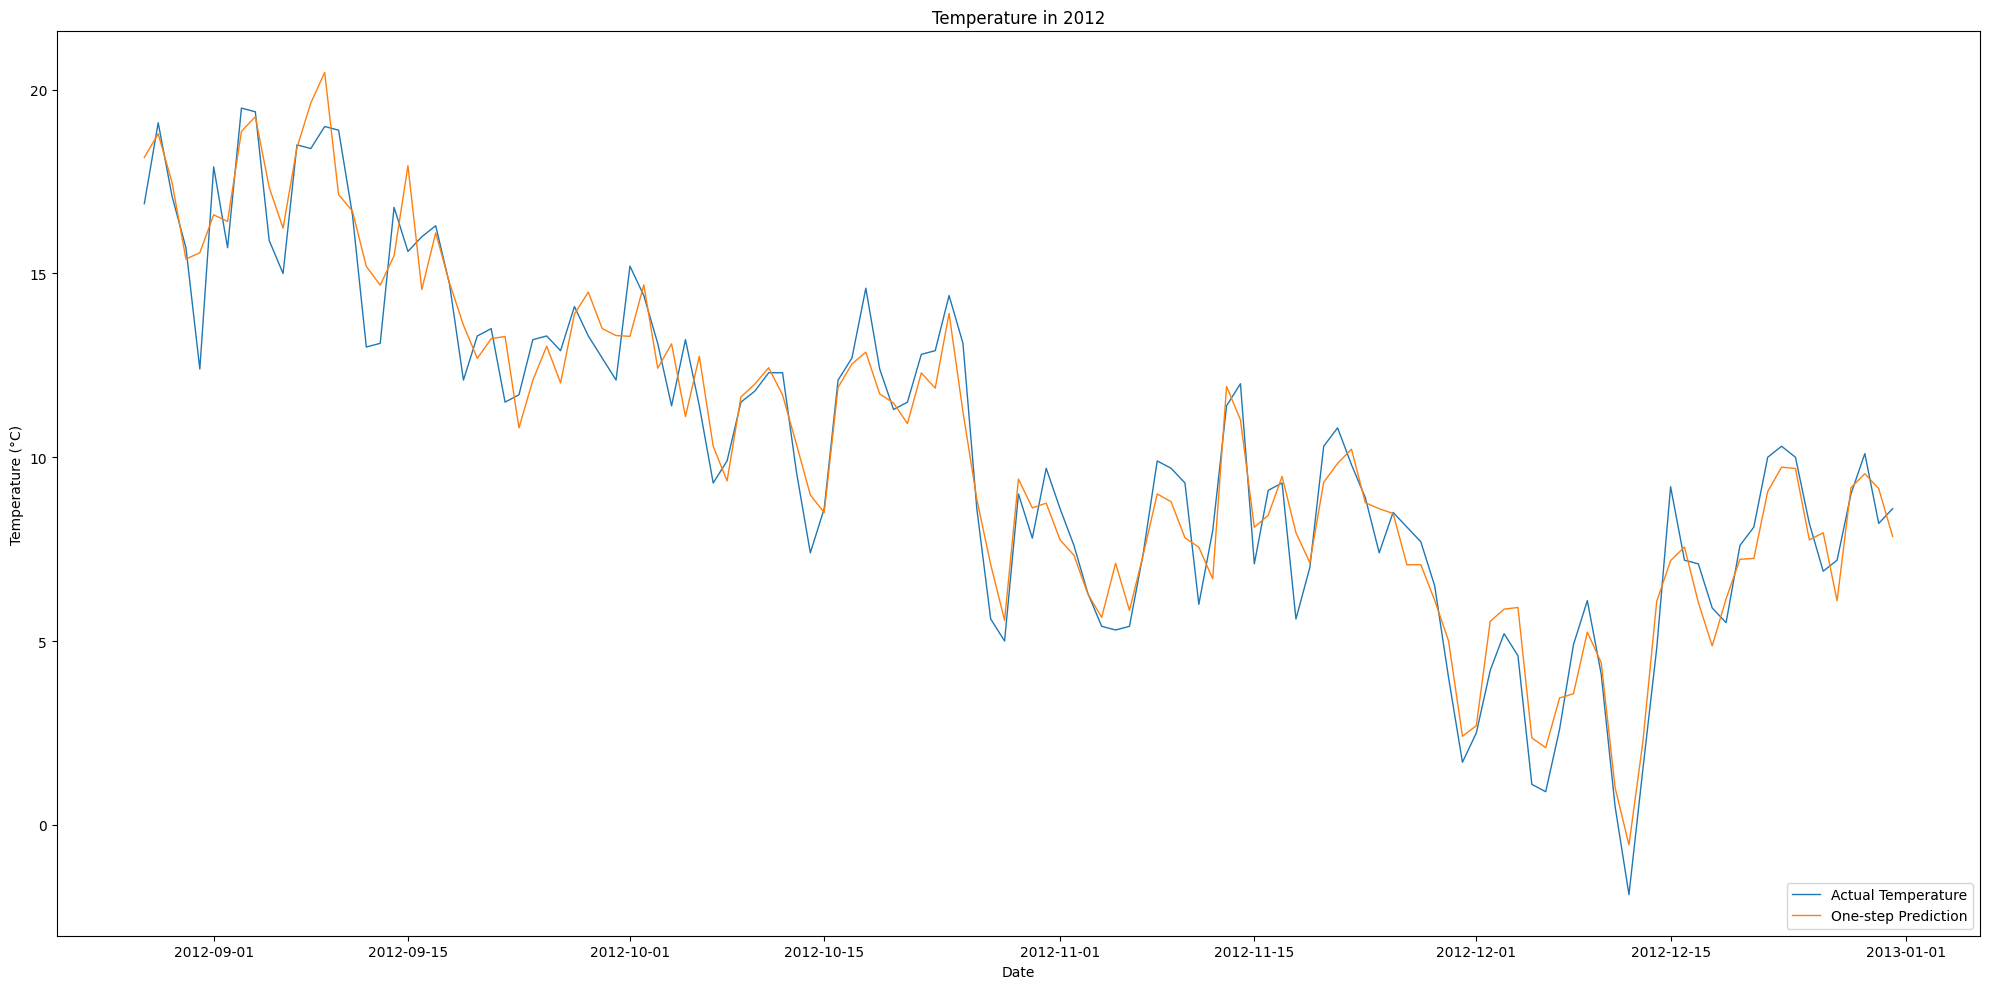

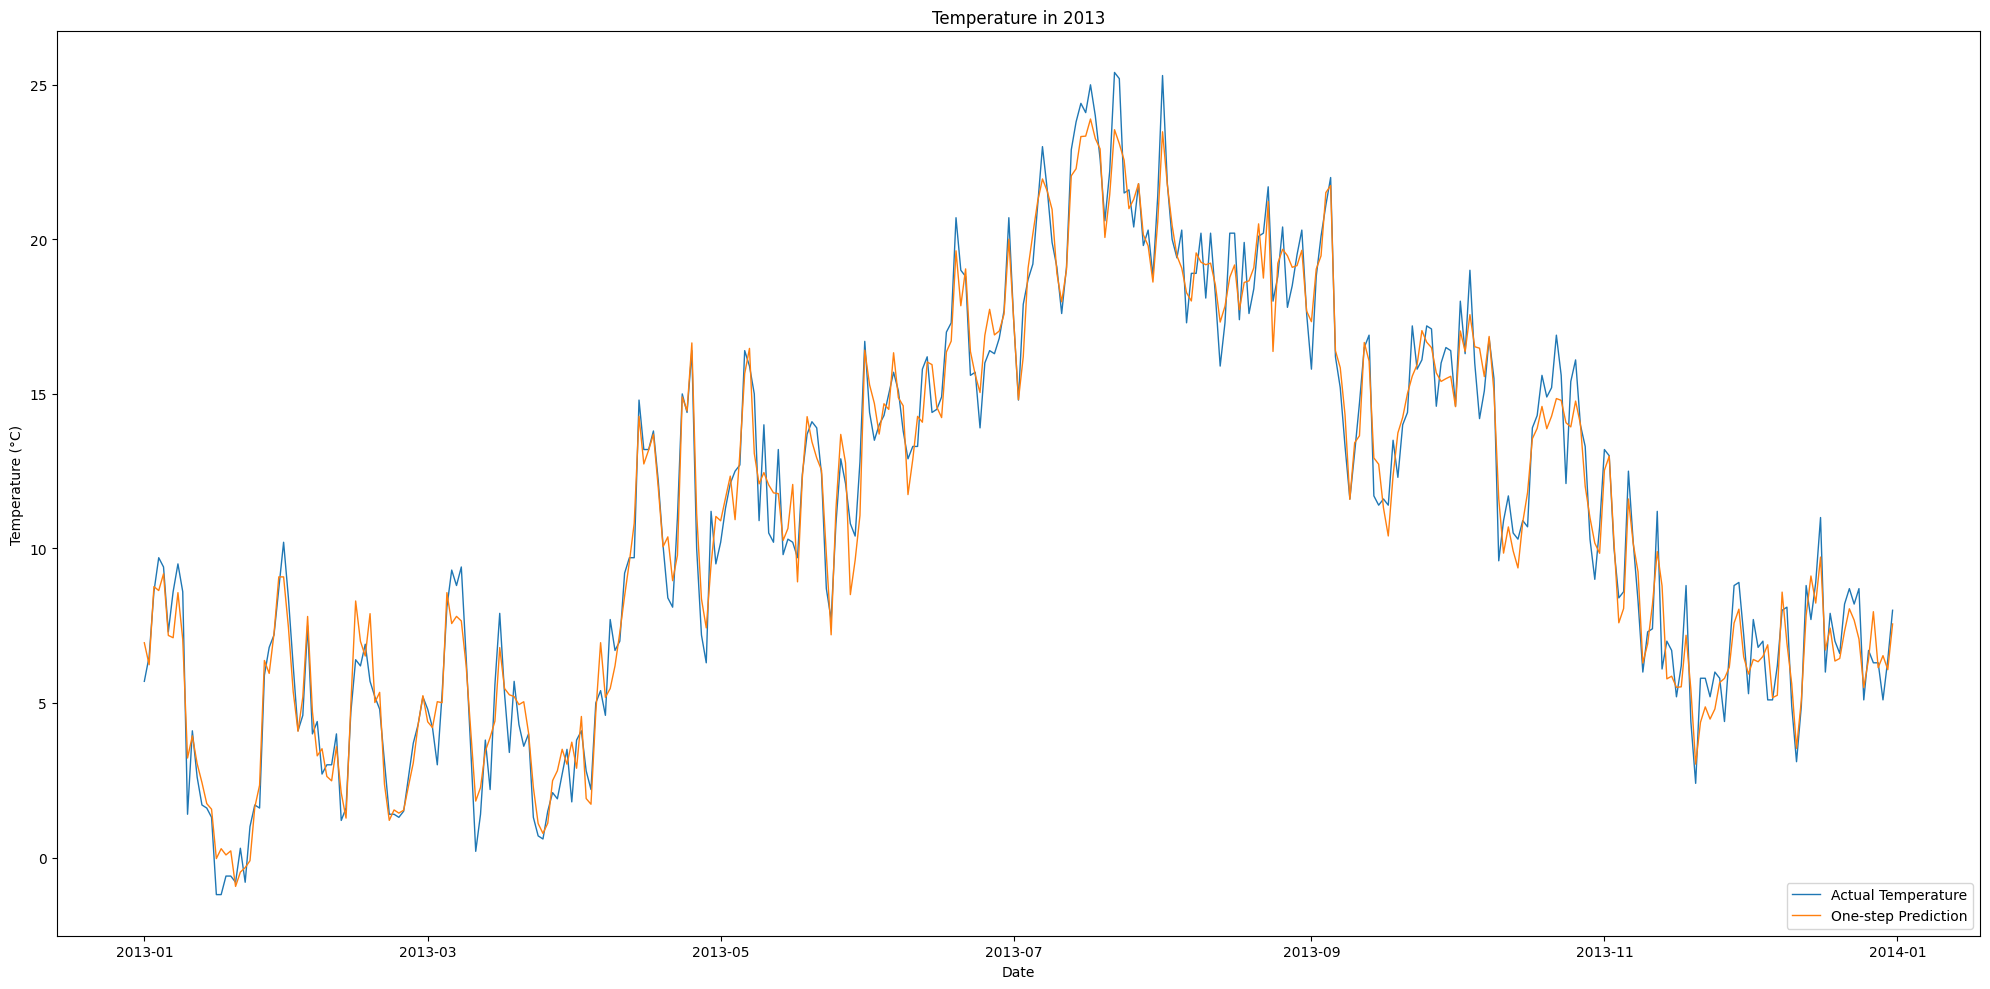

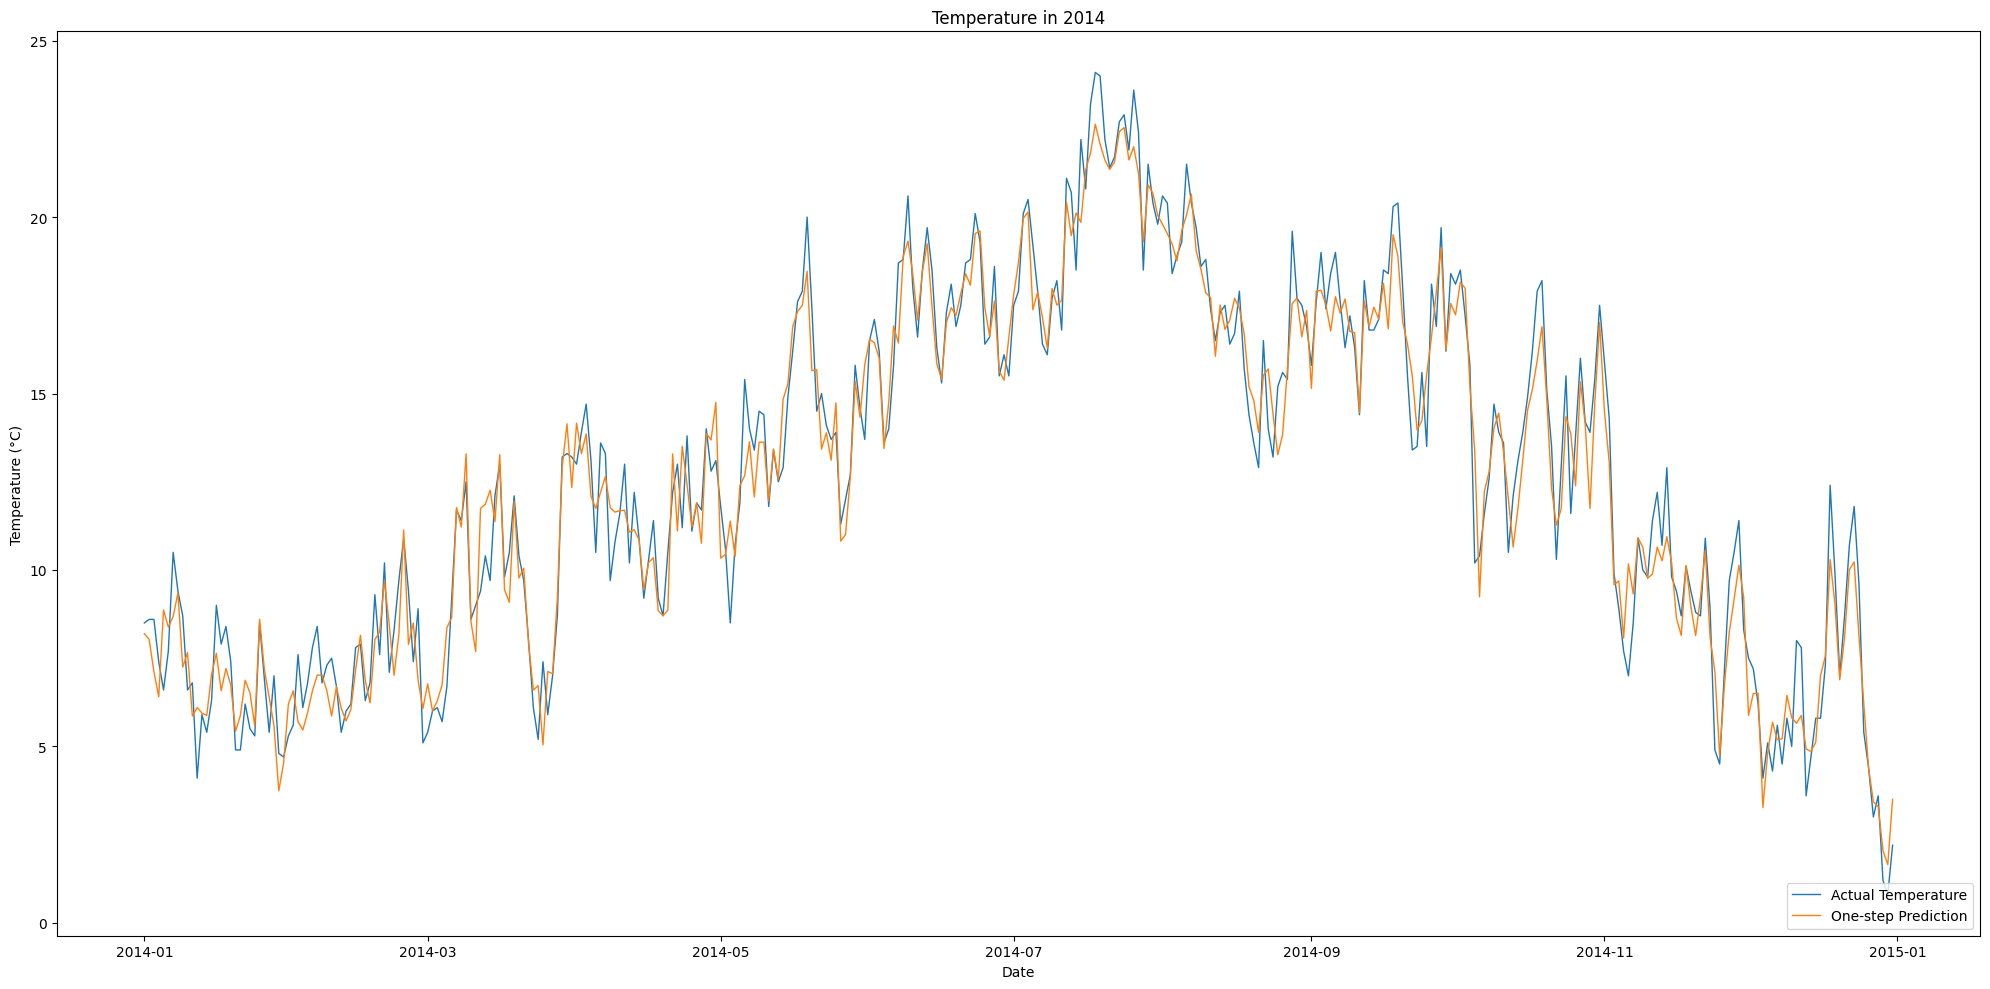

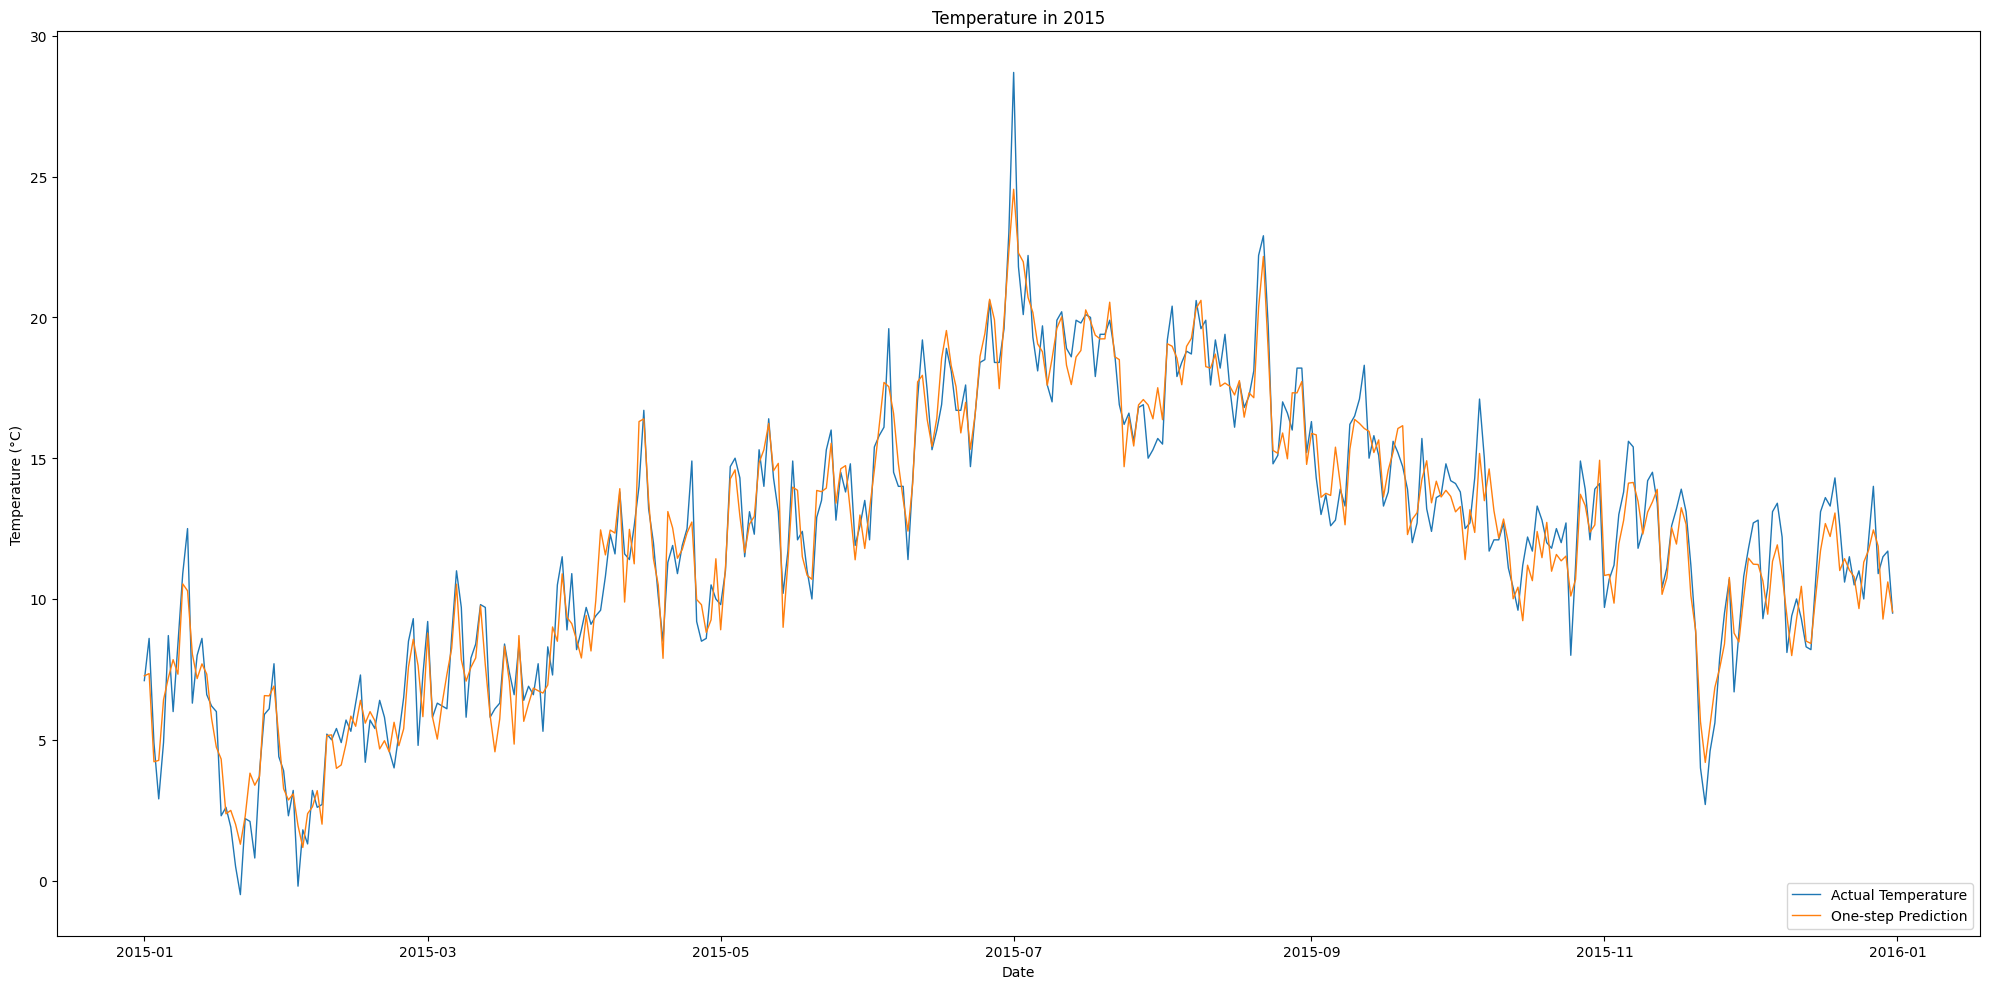

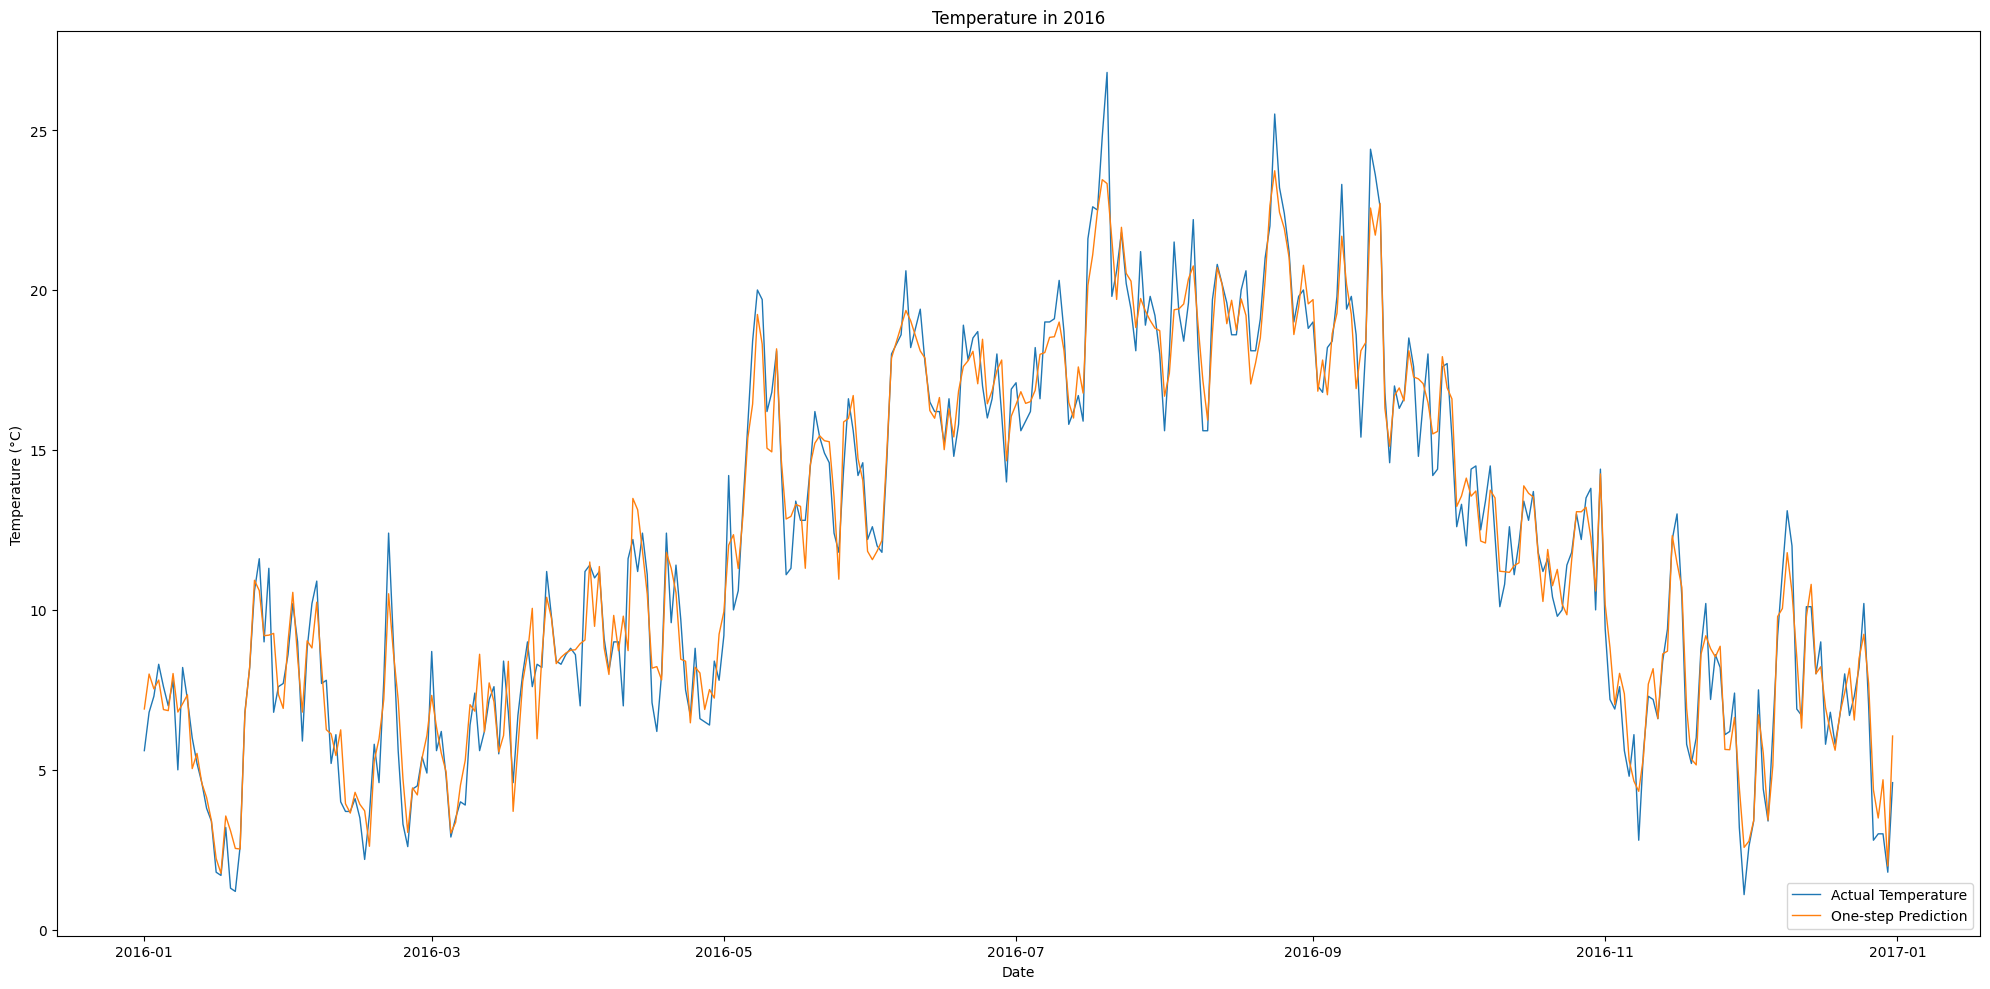

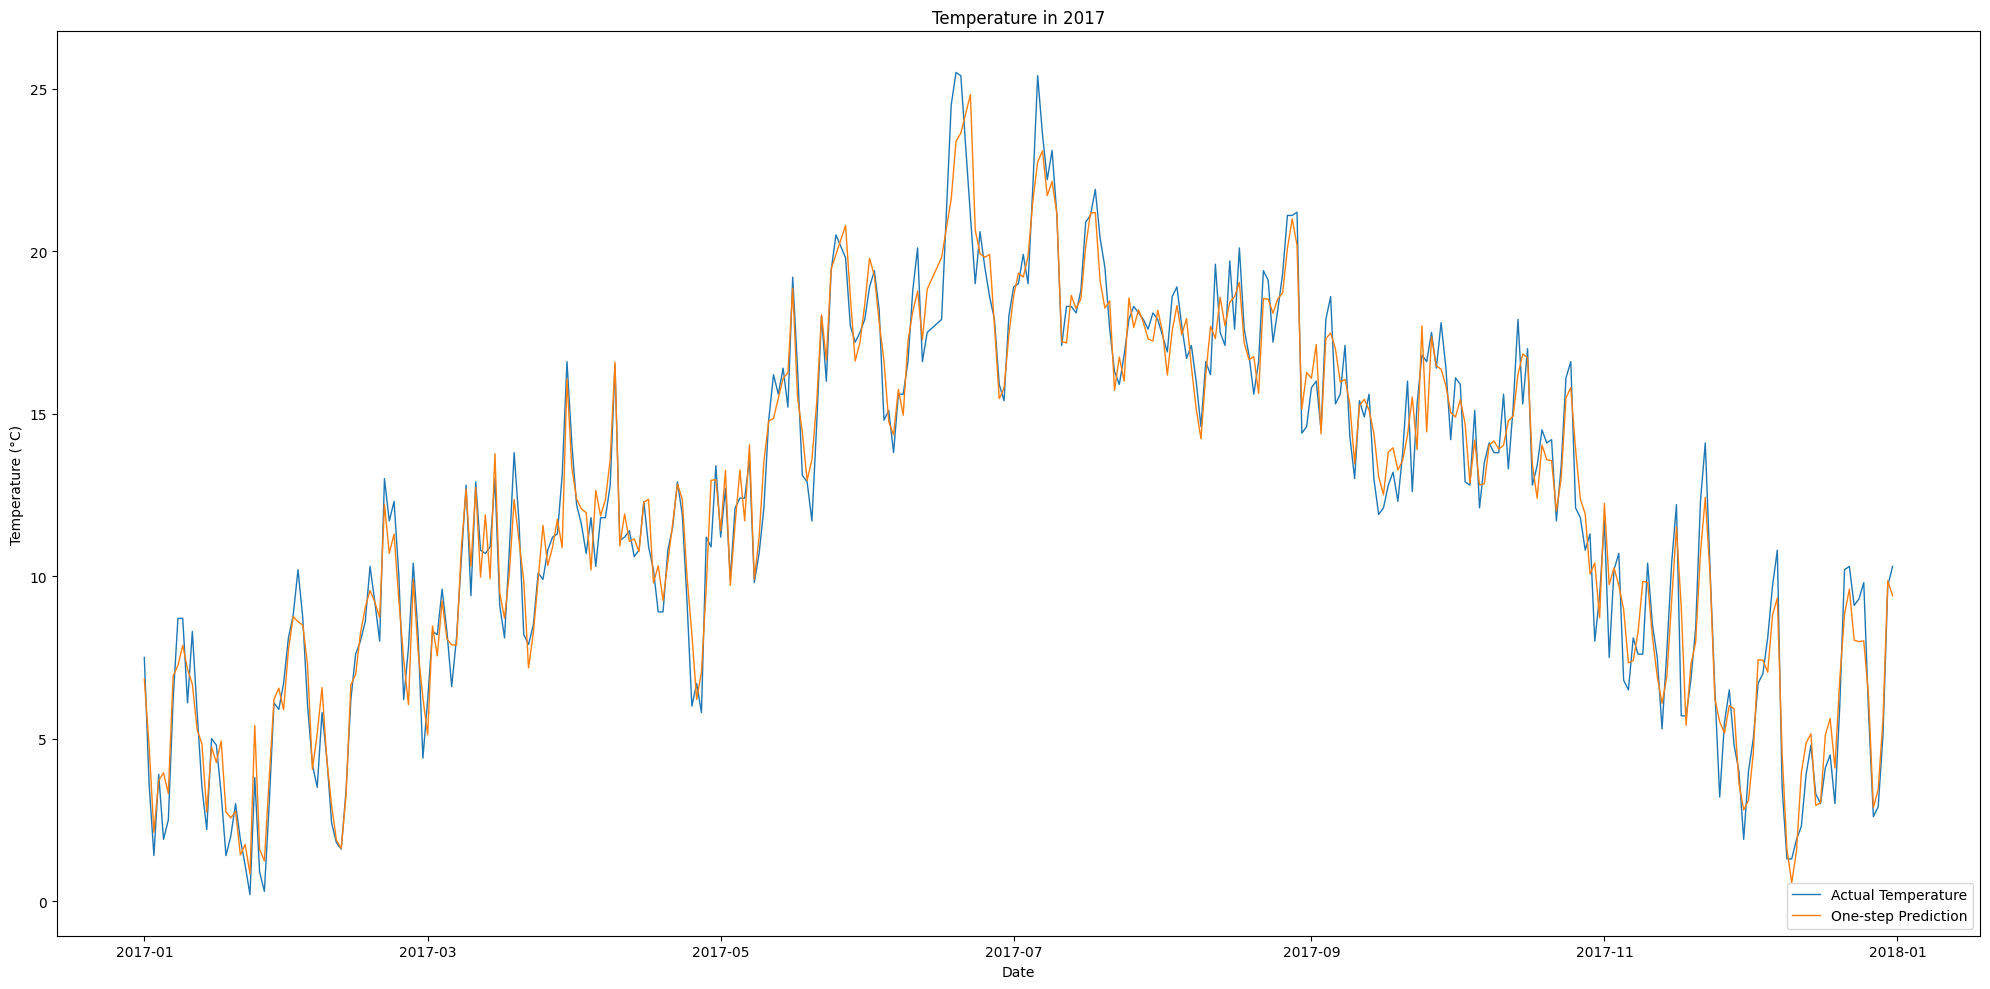

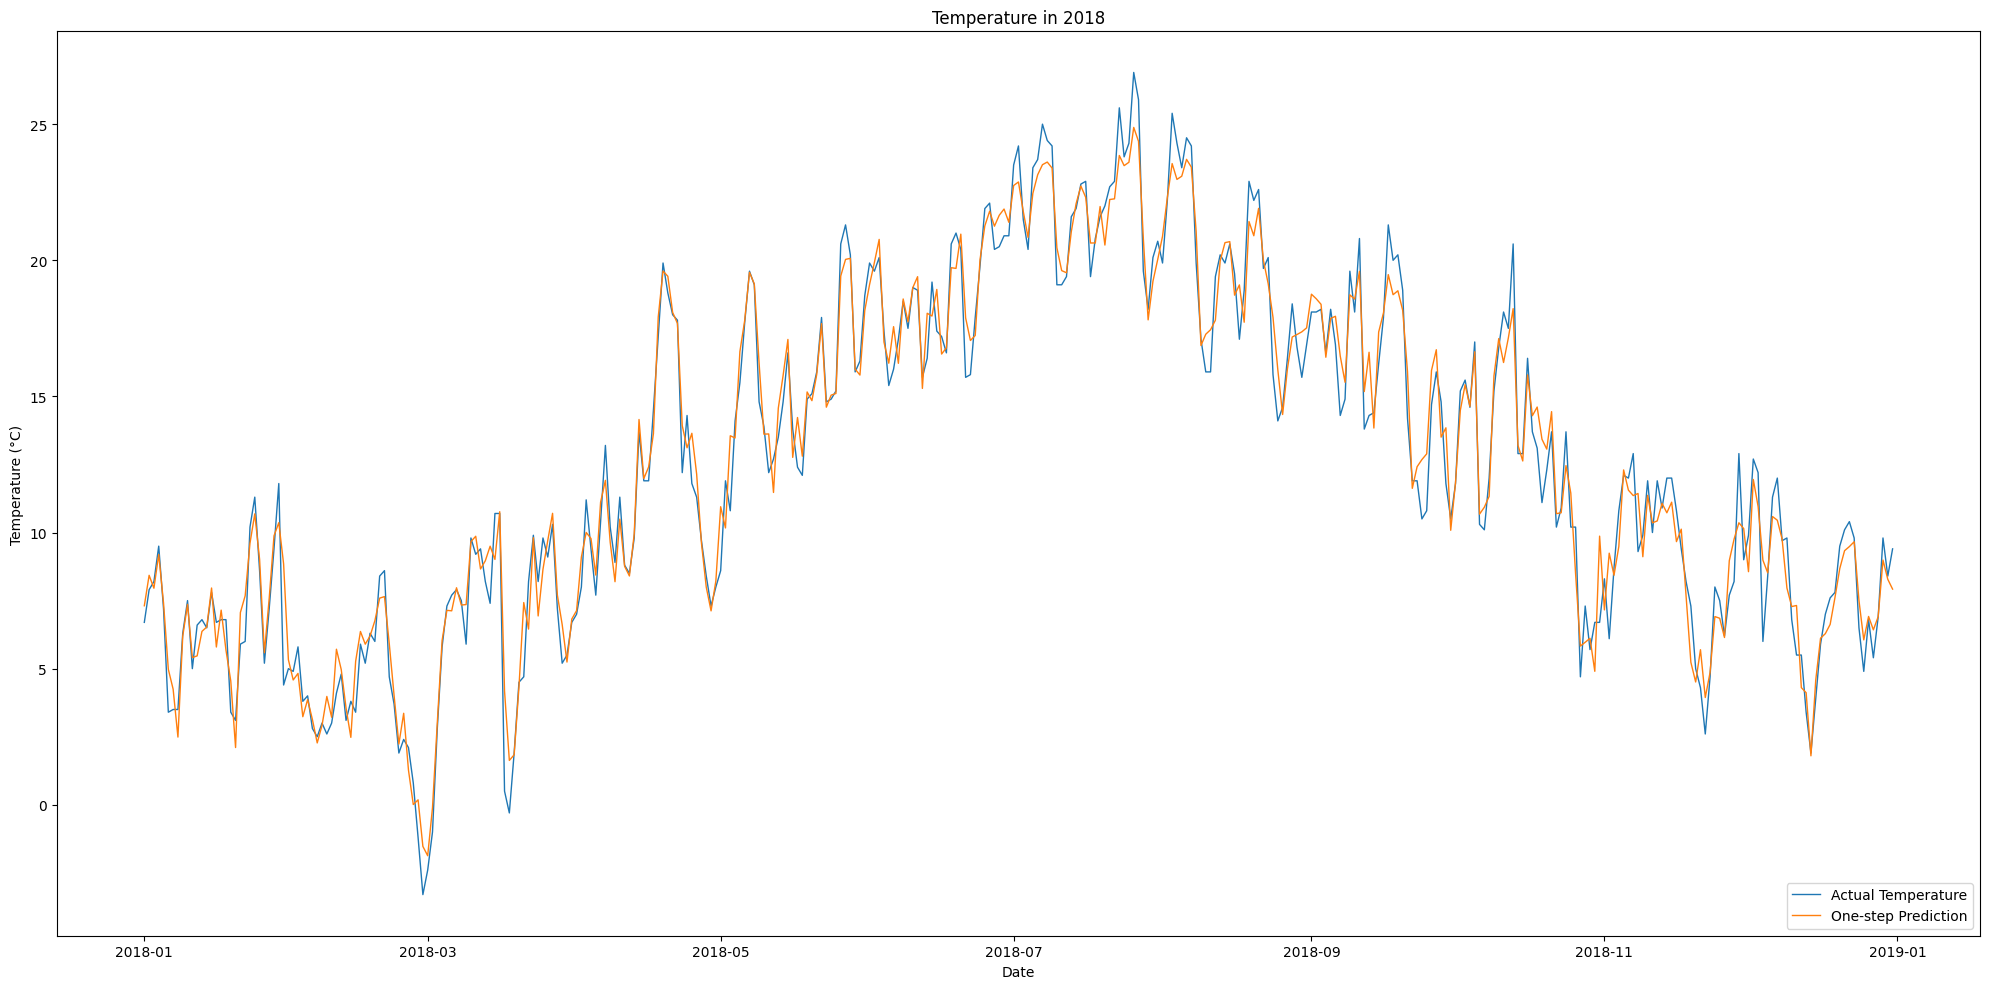

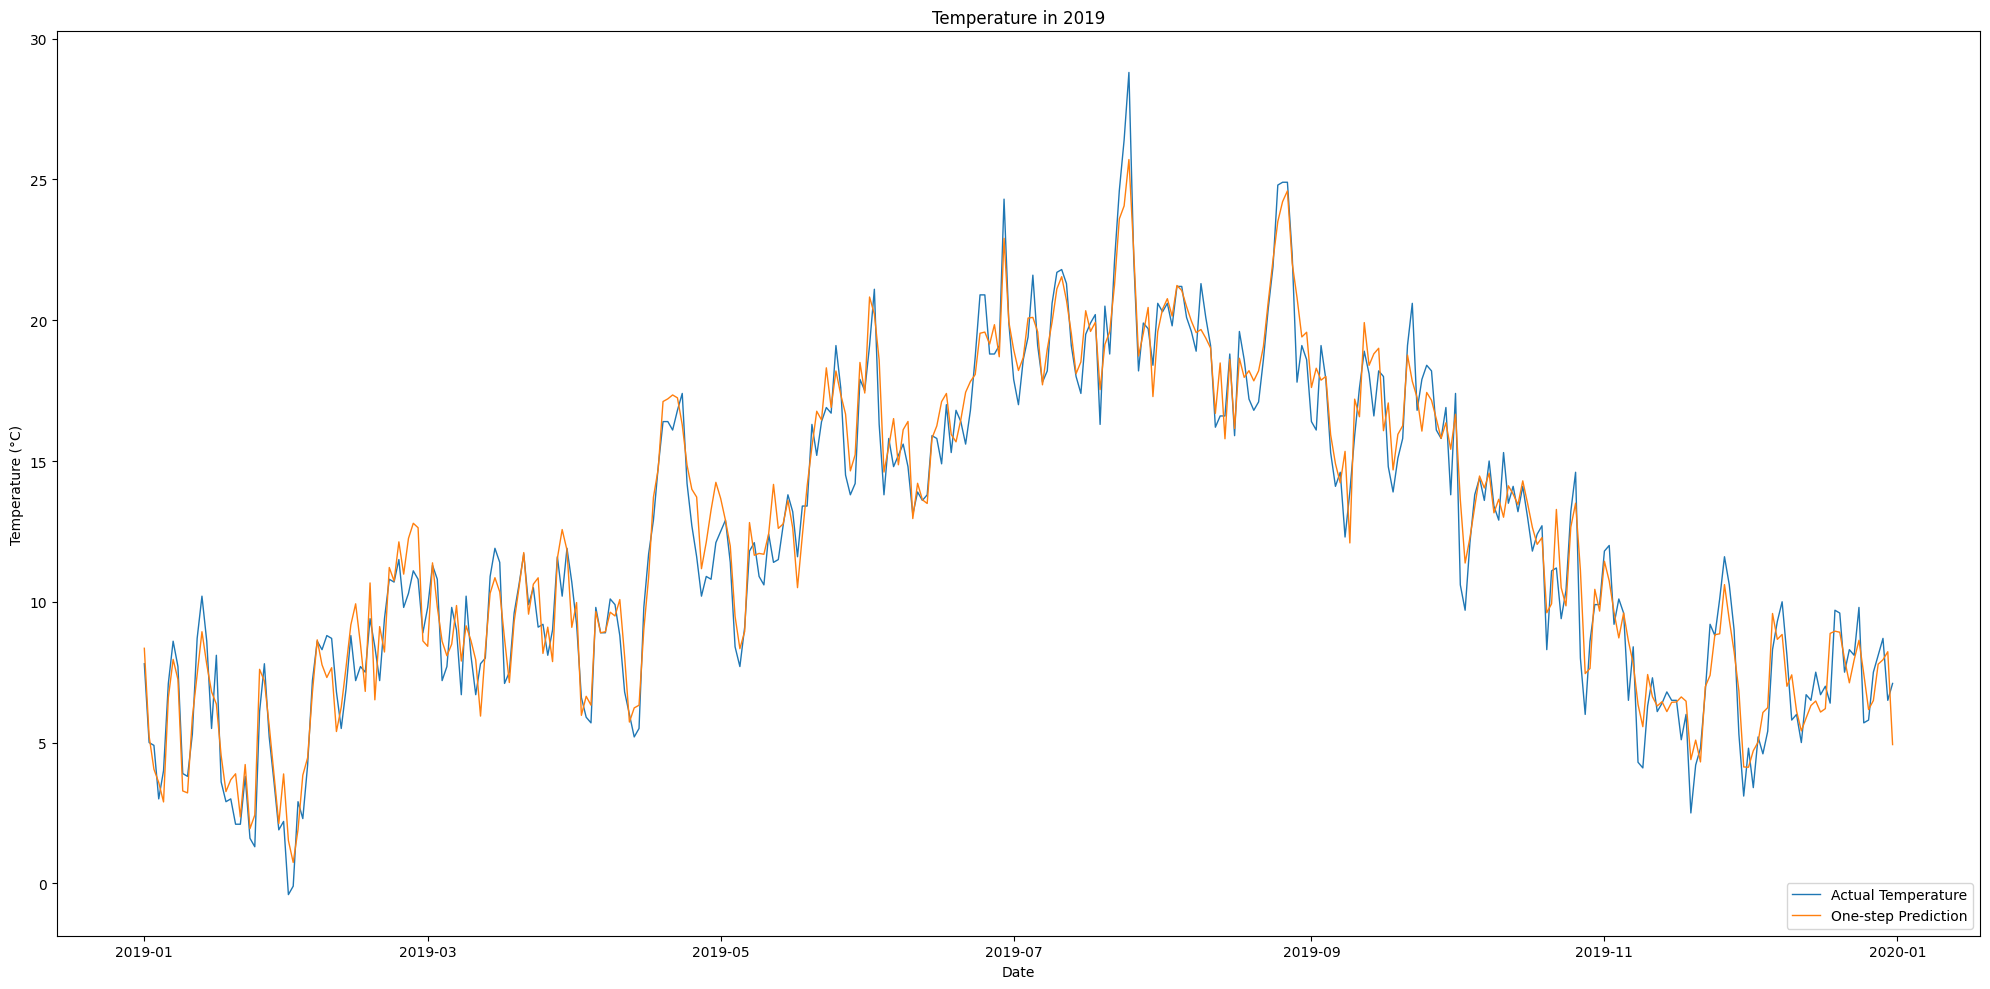

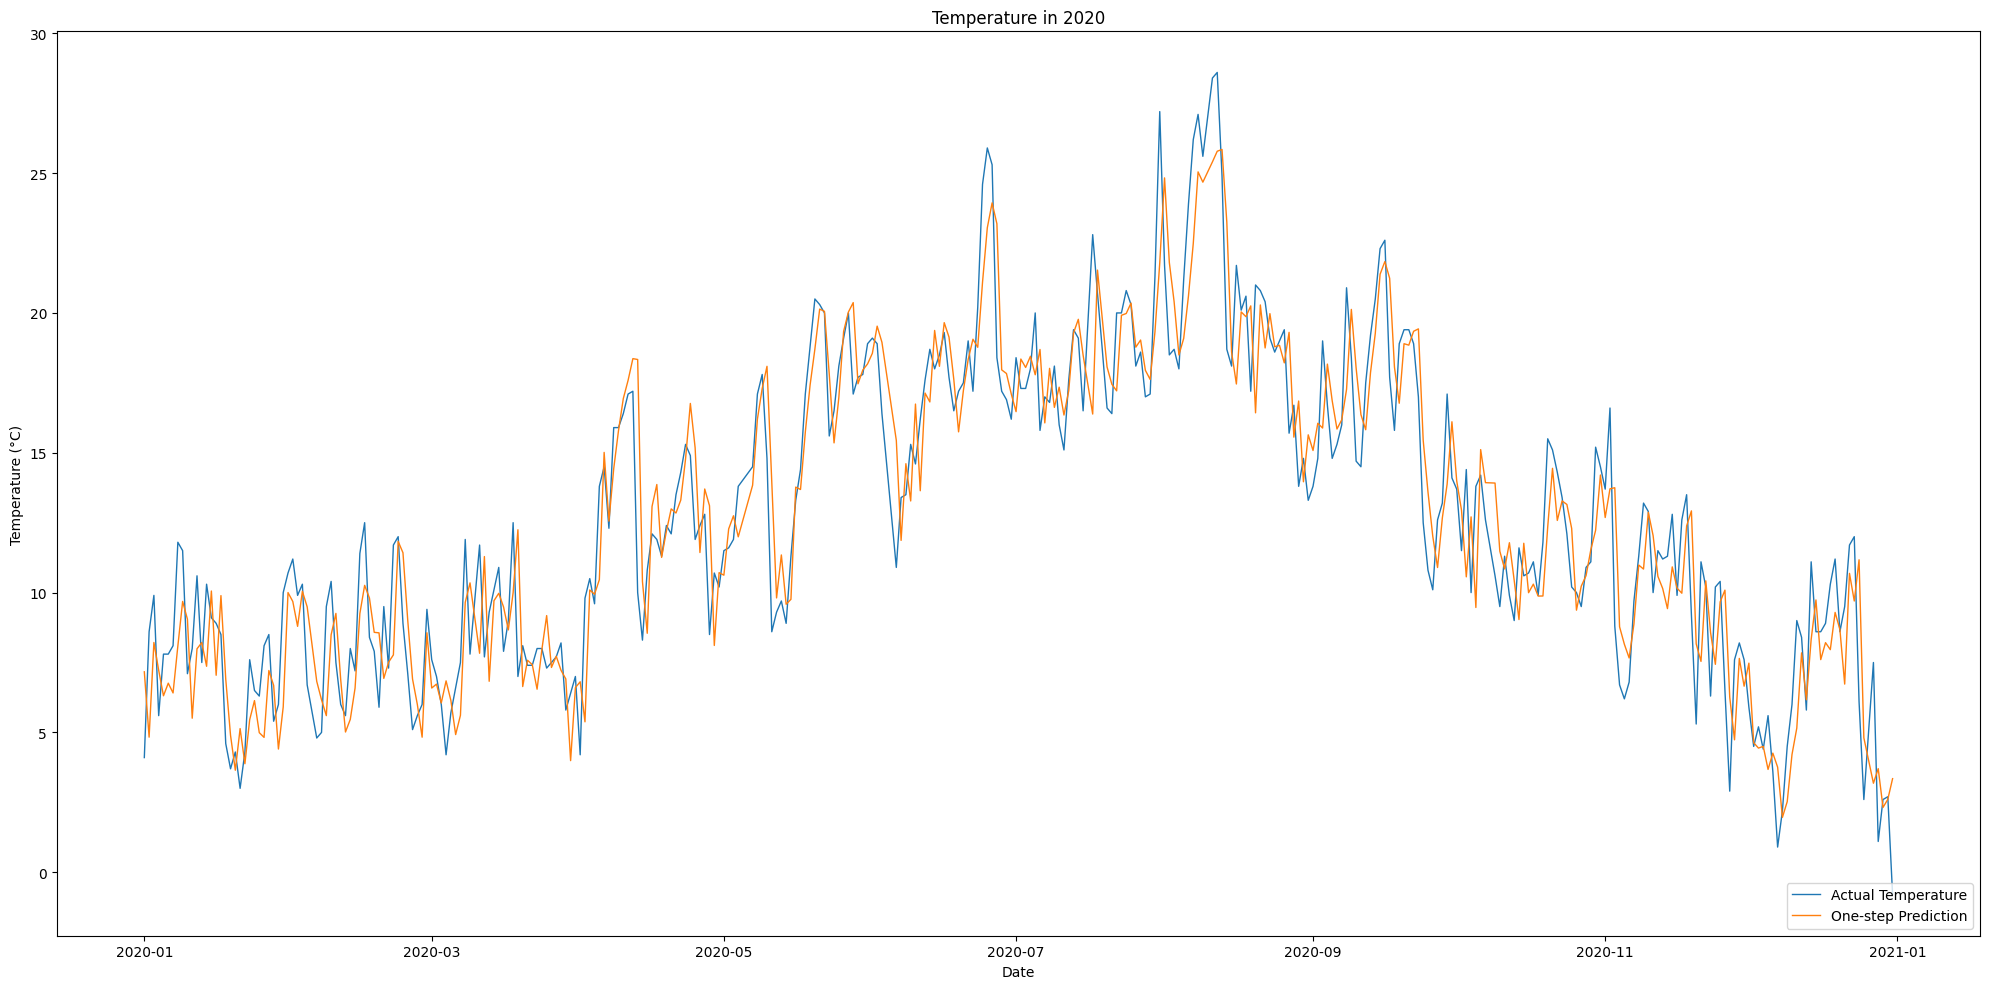

[DISPLAY] Mean square error is: 1.476


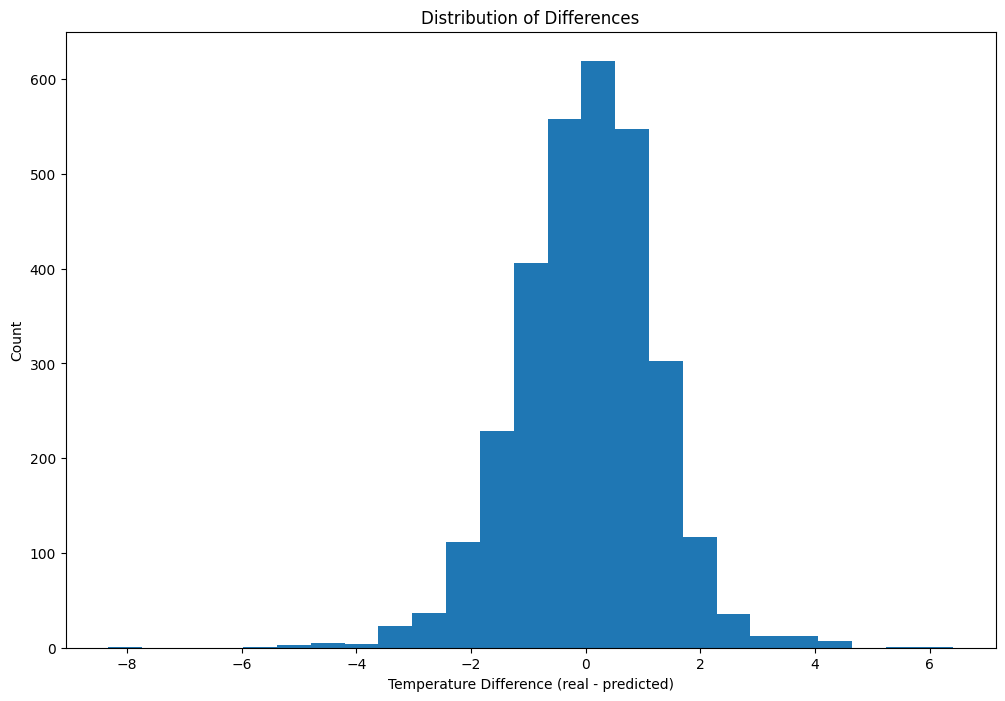

[DISPLAY] Completed in 77.53 seconds
[MAIN] All operations completed
[MAIN] Total execution time: 77.53 seconds

Final Model Performance Metrics:
MAE: 0.9330
MSE: 1.4760
RMSE: 1.2149


In [9]:
main_start_time = time.time()

# Create thread objects
preprocessor = Preprocessing(FILE_PATH)
trainer = Training()
inference = Inference()
analyzer = Analysis()
displayer = Display()

# Start all threads
preprocessor.start()
trainer.start()
inference.start()
analyzer.start()
displayer.start()

# Wait for all threads to complete
preprocessor.join()
trainer.join()
inference.join()
analyzer.join()
displayer.join()

main_end_time = time.time()
print("[MAIN] All operations completed")
print(f"[MAIN] Total execution time: {main_end_time - main_start_time:.2f} seconds")

# Print final metrics
print("\nFinal Model Performance Metrics:")
for metric, value in analysis_results['metrics'].items():
    print(f"{metric}: {value:.4f}")